In [ ]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [ ]:
%matplotlib inline
!pip show tensorflow
!wget -cq https://ti.arc.nasa.gov/c/5 -O naza.zip
!unzip -qqo naza.zip -d battery_data

Name: tensorflow
Version: 2.8.2+zzzcolab20220527125636
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: flatbuffers, gast, protobuf, typing-extensions, h5py, opt-einsum, keras, six, numpy, astunparse, libclang, setuptools, tensorflow-estimator, keras-preprocessing, google-pasta, tensorboard, absl-py, grpcio, tensorflow-io-gcs-filesystem, wrapt, termcolor
Required-by: kapre
[naza.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of naza.zip or
        naza.zip.zip, and cannot find naza.zip.ZIP, period.


In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Text(0.5, 1.0, 'Discharge B0005')

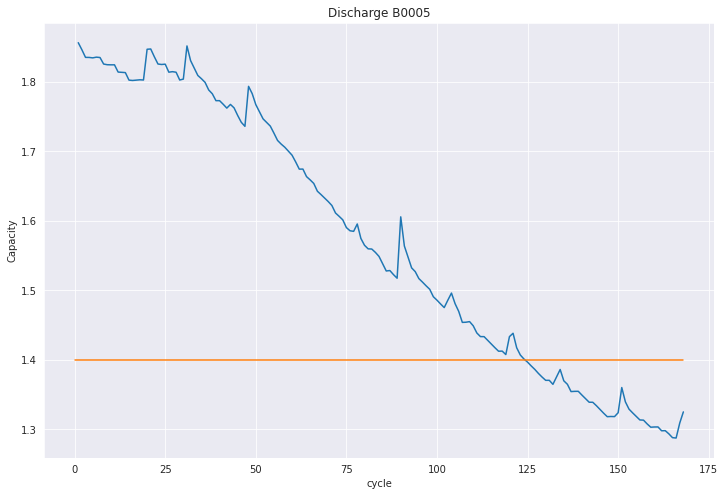

In [ ]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [ ]:
capacity.head()

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,1.856487
1,2,24,2008-04-02 19:43:48,1.846327
2,3,24,2008-04-03 00:01:06,1.835349
3,4,24,2008-04-03 04:16:37,1.835263
4,5,24,2008-04-03 08:33:25,1.834646


In [ ]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


In [ ]:
for i in range(1, len(dis_ele)):
    if (dis_ele.loc[i,"SoH"]>dis_ele.loc[i-1,"SoH"]):
      dis_ele.loc[i,"SoH"]=dis_ele.loc[i-1,"SoH"]

Text(0.5, 1.0, 'Discharge B0005')

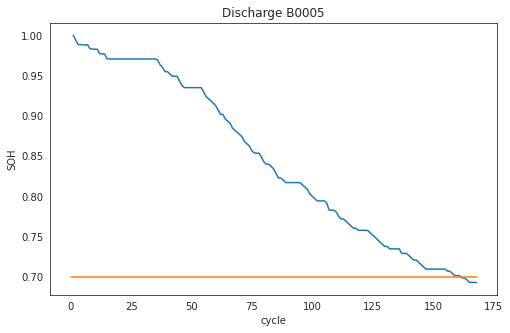

In [ ]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [ ]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [ ]:
dataset

,cycle,capacity
0,1,1.856487
1,2,1.846327
2,3,1.835349
3,4,1.835263
4,5,1.834646
...,...,...
163,164,1.293464
164,165,1.288003
165,166,1.287453
166,167,1.309015


#### Base Model

In [ ]:
def base_model():
  model = Sequential()
  model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dropout(rate=0.25))
  model.add(Dense(1))
  model.summary()
  return model

model = base_model()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 64        
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


The model is trained, 50 epochs are used for training

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 9s 4ms/step - loss: 0.1107
Epoch 2/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0195
Epoch 3/50
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0188
Epoch 4/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0188
Epoch 5/50
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0188
Epoch 6/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0187
Epoch 7/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0186
Epoch 8/50
2012/2012 [==============================] - 5s 3ms/step - loss: 0.0184
Epoch 9/50
2012/2012 [==============================] - 8s 4ms/step - loss: 0.0187
Epoch 10/50
2012/2012 [==============================] - 5s 3ms/step - loss: 0.0187
Epoch 11/50
2012/2012 [==============================] - 5s 3ms/step - loss: 0.0185
Epoch 12/50
2012/2012 [==============================] - 5s 2ms/step - loss: 0.0185
E

Testing 

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
for i in range(1, len(dis_ele)):
    if (dis_ele.loc[i,"SoH"]>dis_ele.loc[i-1,"SoH"]):
      dis_ele.loc[i,"SoH"]=dis_ele.loc[i-1,"SoH"]

Text(0.5, 1.0, 'Discharge B0006')

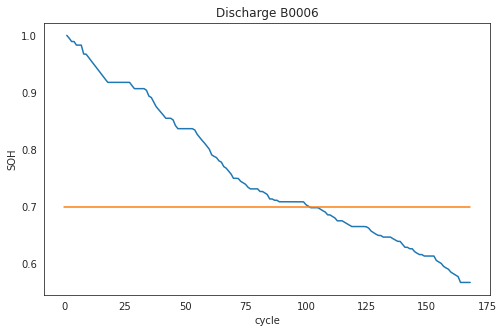

In [ ]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0006')

In [ ]:
capacity_val.head()

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,2.035338
1,2,24,2008-04-02 19:43:48,2.025140
2,3,24,2008-04-03 00:01:06,2.013326
3,4,24,2008-04-03 04:16:37,2.013285
4,5,24,2008-04-03 08:33:25,2.000528


A table is created containing the real SoH and the SoH predicted by the network and the root of the mean square error is calculated.

In [ ]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
for i in range(1, len(new_soh)):
    if (new_soh.loc[i,"SoH"]>new_soh.loc[i-1,"SoH"]):
      new_soh.loc[i,"SoH"]=new_soh.loc[i-1,"SoH"]
new_soh['NewSoH'] = soh_pred
for i in range(1, len(new_soh)):
    if (new_soh.loc[i,"NewSoH"]>new_soh.loc[i-1,"NewSoH"]):
      new_soh.loc[i,"NewSoH"]=new_soh.loc[i-1,"NewSoH"]
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.987076
1      2  0.994990  0.983795
2      3  0.989185  0.979932
3      4  0.989165  0.979917
4      5  0.982898  0.975744
5      6  0.982898  0.975744
6      7  0.982898  0.975744
7      8  0.967304  0.965362
8      9  0.966997  0.965157
9     10  0.961625  0.961579
Root Mean Square Error:  0.0872303534618621


Finally both SoH are plotted to observe their differences

Text(0.5, 1.0, 'Discharge B0006')

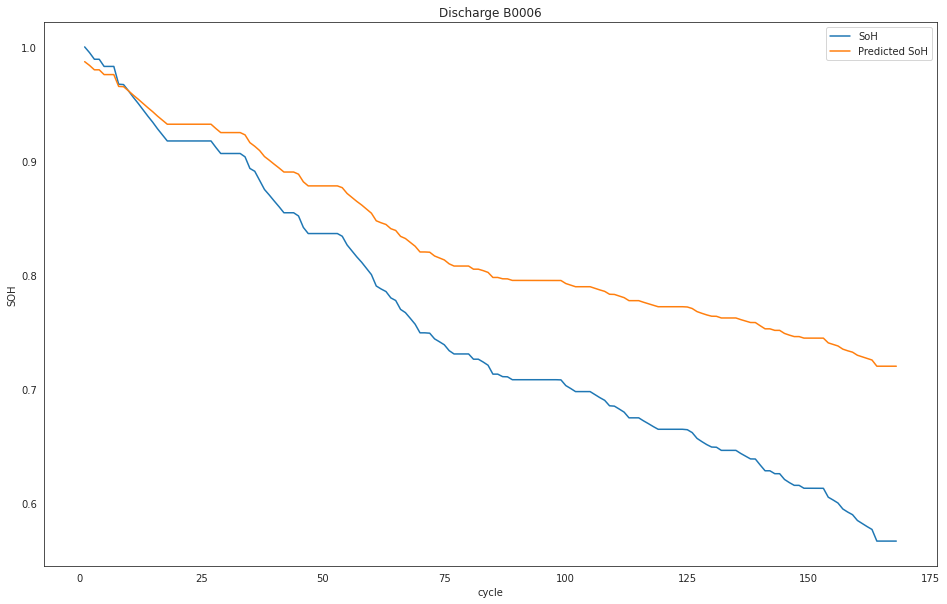

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

In [ ]:
dataset, capacity = load_data('B0007')
dataset.head()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]


,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.891052,4.199360,-0.001866,23.937044,-0.0004,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.891052,4.199497,-0.002139,23.924074,-0.0004,4.215,16.781
2,1,24,2008-04-02 15:25:41,1.891052,3.985606,-1.988778,24.004257,-2.0000,3.003,35.703
3,1,24,2008-04-02 15:25:41,1.891052,3.963247,-1.992558,24.162868,-2.0000,2.987,53.781
4,1,24,2008-04-02 15:25:41,1.891052,3.946647,-1.988491,24.346368,-2.0000,2.972,71.922


In [ ]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


#### Transfer Learning - B0007

In [ ]:
new_model = Sequential()

for i in range(len(model.layers) - 1):
    new_model.add(model.layers[i])

# Freeze the layers 
# for layer in new_model.layers:
#     layer.trainable = False  

new_model.add(Dense(8, activation='relu'))
new_model.add(Dropout(rate=0.2)) 
new_model.add(Dense(1, activation='sigmoid'))
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
new_model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

In [ ]:
new_model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0431
Epoch 2/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0165
Epoch 3/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0125
Epoch 4/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0119
Epoch 5/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0118
Epoch 6/50
2012/2012 [==============================] - 9s 4ms/step - loss: 0.0119
Epoch 7/50
2012/2012 [==============================] - 10s 5ms/step - loss: 0.0119
Epoch 8/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0118
Epoch 9/50
2012/2012 [==============================] - 5s 3ms/step - loss: 0.0116
Epoch 10/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0116
Epoch 11/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0115
Epoch 12/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0115


In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
for i in range(1, len(dis_ele)):
    if (dis_ele.loc[i,"SoH"]>dis_ele.loc[i-1,"SoH"]):
      dis_ele.loc[i,"SoH"]=dis_ele.loc[i-1,"SoH"]
print(dataset_val.head(5))
print(dis_ele.head(5))


Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = new_model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
for i in range(1, len(new_soh)):
    if (new_soh.loc[i,"SoH"]>new_soh.loc[i-1,"SoH"]):
      new_soh.loc[i,"SoH"]=new_soh.loc[i-1,"SoH"]
new_soh['NewSoH'] = soh_pred
for i in range(1, len(new_soh)):
    if (new_soh.loc[i,"NewSoH"]>new_soh.loc[i-1,"NewSoH"]):
      new_soh.loc[i,"NewSoH"]=new_soh.loc[i-1,"NewSoH"]
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.999355
1      2  0.994990  0.998942
2      3  0.989185  0.998192
3      4  0.989165  0.998188
4      5  0.982898  0.996851
5      6  0.982898  0.996844
6      7  0.982898  0.996844
7      8  0.967304  0.987391
8      9  0.966997  0.987153
9     10  0.961625  0.979577
Root Mean Square Error:  0.11802342405193773


Text(0.5, 1.0, 'Discharge B0006')

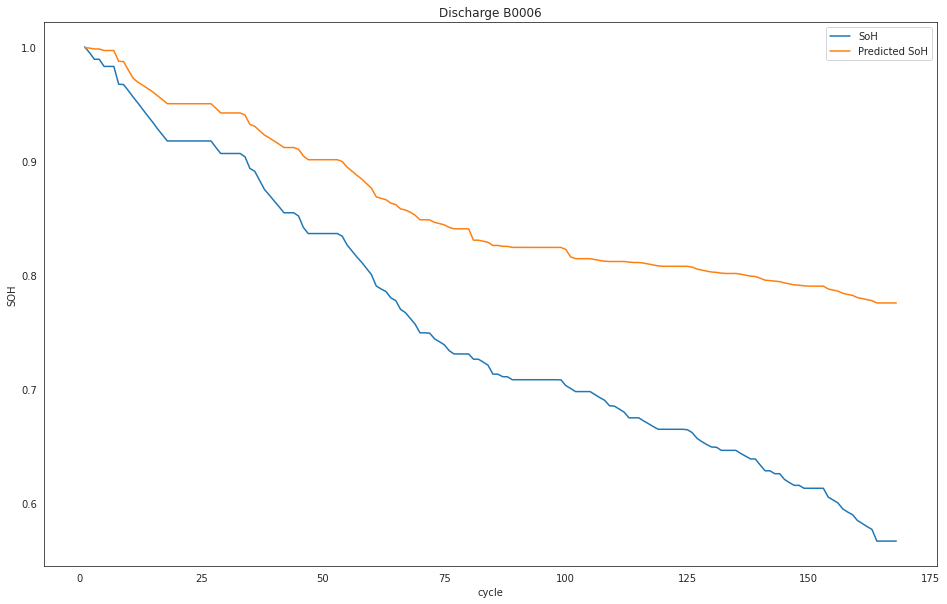

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

#### Transfer Learning - B0018

In [ ]:
dataset, capacity = load_data('B0018')
dataset.head()

Total data in dataset:  319
[1, 24, datetime.datetime(2008, 7, 7, 15, 15, 28), 1.8550045207910817, 4.188108651124536, 0.00013066734156636677, 23.8195202516044, 0.0006, 0.0, 0.0]


,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-07-07 15:15:28,1.855005,4.188109,0.000131,23.819520,0.0006,0.000,0.000
1,1,24,2008-07-07 15:15:28,1.855005,4.188196,0.001459,23.828807,0.0006,4.203,9.422
2,1,24,2008-07-07 15:15:28,1.855005,3.977432,-2.005672,23.844944,1.9988,3.029,19.578
3,1,24,2008-07-07 15:15:28,1.855005,3.961974,-2.012206,23.925577,1.9988,3.026,29.016
4,1,24,2008-07-07 15:15:28,1.855005,3.949835,-2.012005,24.010628,1.9988,3.015,38.485


In [ ]:
new_model_1 = Sequential()

for i in range(len(model.layers) - 1):
    new_model_1.add(model.layers[i])

# Freeze the layers 
# for layer in new_model.layers:
#     layer.trainable = False  


new_model_1.add(Dense(6, activation='relu'))
new_model_1.add(Dropout(rate=0.3)) 
new_model_1.add(Dropout(rate=0.25))
new_model_1.add(Dense(9, activation='relu'))
new_model_1.add(Dense(8, activation='relu'))
new_model_1.add(Dropout(rate=0.25))
new_model_1.add(Dense(1, activation='sigmoid'))
new_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 6)                 54        
                                                                 
 dropout_2 (Dropout)         (None, 6)                 0         
                                                                 
 dropout_3 (Dropout)         (None, 6)                

In [ ]:
new_model_1.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')
new_model_1.fit(x=train_dataset, y=np.array(soh), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0535
Epoch 2/50
2012/2012 [==============================] - 6s 3ms/step - loss: 0.0304
Epoch 3/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0280
Epoch 4/50
2012/2012 [==============================] - 9s 5ms/step - loss: 0.0277
Epoch 5/50
2012/2012 [==============================] - 8s 4ms/step - loss: 0.0272
Epoch 6/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0273
Epoch 7/50
2012/2012 [==============================] - 7s 4ms/step - loss: 0.0270
Epoch 8/50
2012/2012 [==============================] - 7s 3ms/step - loss: 0.0266
Epoch 9/50
2012/2012 [==============================] - 5s 3ms/step - loss: 0.0266
Epoch 10/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.0263
Epoch 11/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0262
Epoch 12/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0260
E

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
for i in range(1, len(new_soh)):
    if (dis_ele.loc[i,"SoH"]>dis_ele.loc[i-1,"SoH"]):
      dis_ele.loc[i,"SoH"]=dis_ele.loc[i-1,"SoH"]
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [ ]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = new_model_1.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
for i in range(1, len(new_soh)):
    if (new_soh.loc[i,"SoH"]>new_soh.loc[i-1,"SoH"]):
      new_soh.loc[i,"SoH"]=new_soh.loc[i-1,"SoH"]
new_soh['NewSoH'] = soh_pred
for i in range(1, len(new_soh)):
    if (new_soh.loc[i,"NewSoH"]>new_soh.loc[i-1,"NewSoH"]):
      new_soh.loc[i,"NewSoH"]=new_soh.loc[i-1,"NewSoH"]
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.903828
1      2  0.994990  0.899832
2      3  0.989185  0.888169
3      4  0.989165  0.887626
4      5  0.982898  0.870745
5      6  0.982898  0.870570
6      7  0.982898  0.870570
7      8  0.967304  0.819495
8      9  0.966997  0.817448
9     10  0.961625  0.795705
Root Mean Square Error:  0.08518824612637904


Text(0.5, 1.0, 'Discharge B0006')

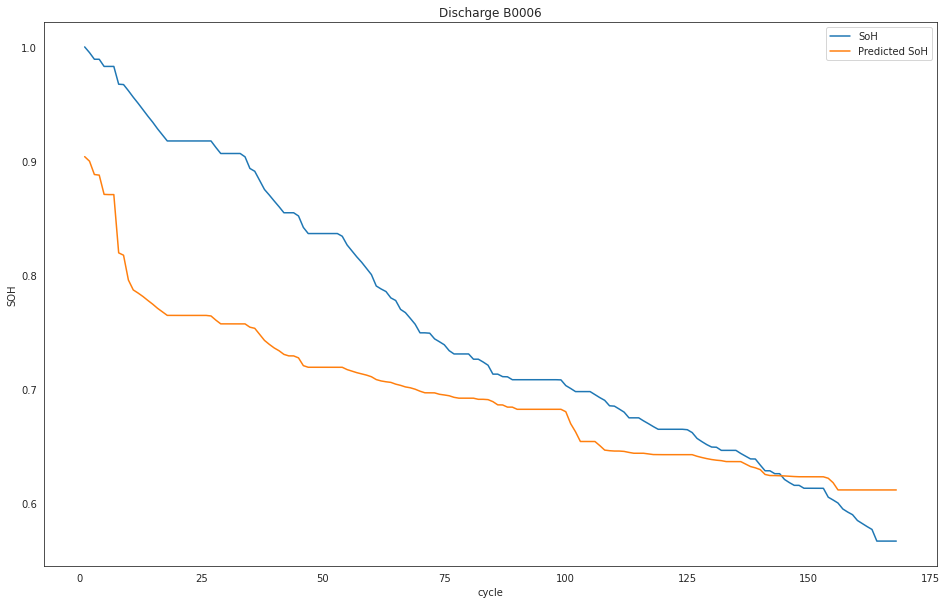

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# RUL estimation


In [ ]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
print(dataset)
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
     cycle  capacity
0        1  1.856487
1        2  1.846327
2        3  1.835349
3        4  1.835263
4        5  1.834646
..     ...       ...
163    164  1.293464
164    165  1.288003
165    166  1.287453
166    167  1.309015
167    168  1.325079

[168 rows x 2 columns]


In [ ]:
data_set_train

array([[1.        ],
       [0.91561044],
       [0.8244276 ],
       [0.82370776],
       [0.81858284],
       [0.82702292],
       [0.82274107],
       [0.74475387],
       [0.73658968],
       [0.73525587],
       [0.73530807],
       [0.64878019],
       [0.64504437],
       [0.64245569],
       [0.55239887],
       [0.5483198 ],
       [0.55224518],
       [0.55630523],
       [0.55389079],
       [0.92141416],
       [0.92466441],
       [0.83130679],
       [0.74495286],
       [0.73941195],
       [0.74329796],
       [0.64736147],
       [0.65349179],
       [0.64684867],
       [0.55379145],
       [0.56468362],
       [0.96108786],
       [0.78584371],
       [0.69614198],
       [0.60813125],
       [0.56910955],
       [0.52564601],
       [0.43483049],
       [0.38898028],
       [0.30684029],
       [0.30687384],
       [0.26396841],
       [0.21781209],
       [0.26185191],
       [0.22074648],
       [0.1298974 ],
       [0.04782759],
       [0.        ],
       [0.477

#### Base model

In [ ]:
def base_model():
  regress = Sequential()
  regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
  regress.add(Dropout(0.3))
  regress.add(LSTM(units=200, return_sequences=True))
  regress.add(Dropout(0.3))
  regress.add(LSTM(units=200, return_sequences=True))
  regress.add(Dropout(0.3))
  regress.add(LSTM(units=200))
  regress.add(Dropout(0.3))
  regress.add(Dense(units=1))
  regress.summary()
  return regress

model = base_model()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=25)

Epoch 1/200
2/2 [==============================] - 8s 94ms/step - loss: 0.3121
Epoch 2/200
2/2 [==============================] - 0s 90ms/step - loss: 0.1272
Epoch 3/200
2/2 [==============================] - 0s 86ms/step - loss: 0.0968
Epoch 4/200
2/2 [==============================] - 0s 86ms/step - loss: 0.0588
Epoch 5/200
2/2 [==============================] - 0s 94ms/step - loss: 0.0792
Epoch 6/200
2/2 [==============================] - 0s 96ms/step - loss: 0.0583
Epoch 7/200
2/2 [==============================] - 0s 97ms/step - loss: 0.0528
Epoch 8/200
2/2 [==============================] - 0s 98ms/step - loss: 0.0700
Epoch 9/200
2/2 [==============================] - 0s 97ms/step - loss: 0.0425
Epoch 10/200
2/2 [==============================] - 0s 94ms/step - loss: 0.0468
Epoch 11/200
2/2 [==============================] - 0s 96ms/step - loss: 0.0580
Epoch 12/200
2/2 [==============================] - 0s 102ms/step - loss: 0.0501
Epoch 13/200
2/2 [==============================

In [ ]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [ ]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=model.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

(119, 1)
Test RMSE: 0.058


0.8139511340103143

In [ ]:
tests

,capacity
49,1.767364
50,1.757018
51,1.746871
52,1.741717
53,1.736423
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


As can be seen, the mean RMSE is 0.05 (5%), which is very close to the values observed in the literature using this type of network.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

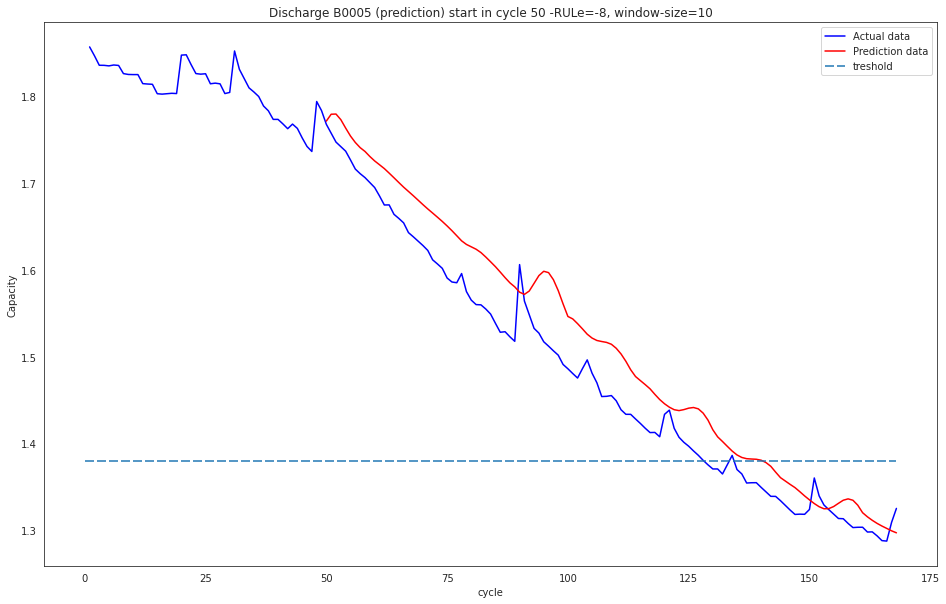

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

In [ ]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 140
The error of RUL= 12 Cycle(s)


#### Transfer Learning 

In [ ]:
new_model_1 = Sequential()

for i in range(len(model.layers) - 1):
    new_model_1.add(model.layers[i])

# Freeze the layers 
# for layer in new_model.layers:
#     layer.trainable = False  


new_model_1.add(Dense(6, activation='relu'))
new_model_1.add(Dropout(rate=0.3)) 
new_model_1.add(Dropout(rate=0.25))
new_model_1.add(Dense(9, activation='relu'))
new_model_1.add(Dropout(0.3))
new_model_1.add(Dense(1, activation='sigmoid'))
new_model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           161600    
                                                                 
 dropout_8 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_9 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           320800    
                                                                 
 dropout_10 (Dropout)        (None, 10, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)              

In [ ]:
model.fit(X_train,y_train,epochs=200,batch_size=20)

Epoch 1/200
2/2 [==============================] - 0s 114ms/step - loss: 0.0258
Epoch 2/200
2/2 [==============================] - 0s 145ms/step - loss: 0.0256
Epoch 3/200
2/2 [==============================] - 0s 162ms/step - loss: 0.0301
Epoch 4/200
2/2 [==============================] - 0s 148ms/step - loss: 0.0212
Epoch 5/200
2/2 [==============================] - 0s 166ms/step - loss: 0.0248
Epoch 6/200
2/2 [==============================] - 0s 140ms/step - loss: 0.0238
Epoch 7/200
2/2 [==============================] - 0s 173ms/step - loss: 0.0243
Epoch 8/200
2/2 [==============================] - 0s 135ms/step - loss: 0.0236
Epoch 9/200
2/2 [==============================] - 0s 159ms/step - loss: 0.0272
Epoch 10/200
2/2 [==============================] - 0s 142ms/step - loss: 0.0228
Epoch 11/200
2/2 [==============================] - 0s 160ms/step - loss: 0.0218
Epoch 12/200
2/2 [==============================] - 0s 146ms/step - loss: 0.0249
Epoch 13/200
2/2 [===================

In [ ]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [ ]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=model.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

(119, 1)
Test RMSE: 0.229


-1.8629644491105406

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

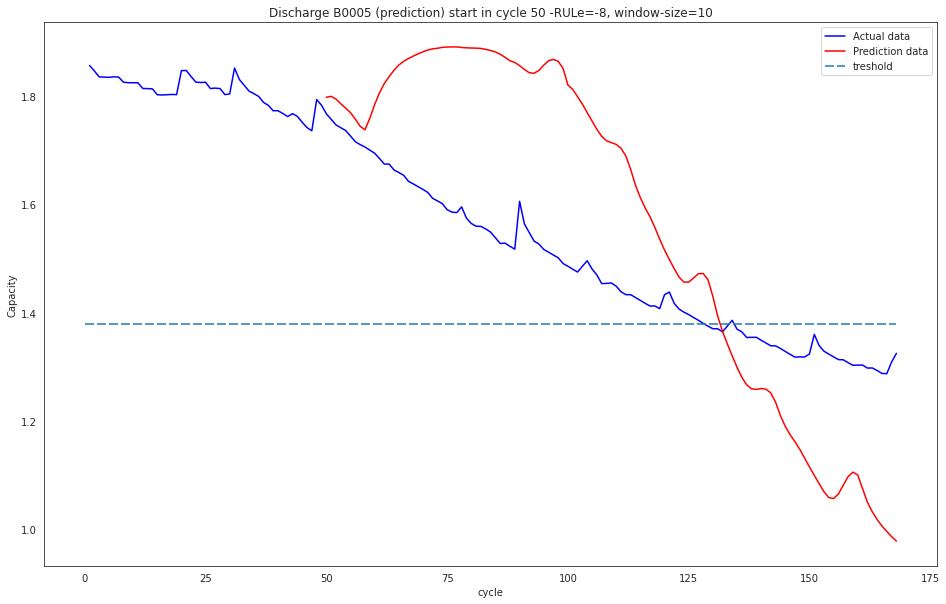

In [ ]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

In [ ]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 131
The error of RUL= 3 Cycle(s)
